## Periscope Table/View Dependency Tree

Following loosely Periscope tutorial below although this code proved to need formatting and refactoring.

https://www.sisense.com/blog/automated-identification-and-graphing-of-sql-dependencies/


### Pseudo Code

1. Clone the Periscope Repository with folder structure
2. Iterate over the Files with .sql extension
3. Create df with: id, category (view, table, chart), sql code
3. For each file ending with .sql extension, write the filename, category, and first word between '' and after 'FROM' or 'JOIN'


Packages used: 

os—used to access  the current working directory

argparse—parses command line arguments

re—regex library for parsing out table names from SQL

csv—a library for navigating CSV files

networkx—modern Python graphviz library used for both creating and visualizing the directed acyclical graph

## 1. Setup


In [1]:
# Imports

import os
import csv
import pandas as pd
import re
import networkx as nx
import matplotlib
import scipy

home = os.path.expanduser("~")

In [2]:
# accessing a cloned git repo with the Periscope folder structure containing views and dashboards 

# !cd ~/Desktop/periscope

## 2. Iterate over the Files with .sql extension


In [27]:
# Build a dict consisting of view name and sql code only

query_map = {}

for dirpath, dirs, files in os.walk("/home/lucia/Desktop/periscope/views"):	
    for filename in files:
#         print(filename)
        if filename.endswith(".sql"):
            fname = os.path.join(dirpath,filename)
            with open(fname) as myfile:
                query_map[os.path.basename(fname).split(".")[0]] = myfile.read()

## 3. Create Df with: id, category (view, table, chart), code


In [6]:
tree_df = pd.DataFrame(list(query_map.items()), columns=['name', 'sql'])

tree_df['type'] = 'view' # testing views only for now

tree_df

,name,sql,type
0,view_cumulative_reserves,"--yes_cahce\nselect\n vc.user_id\n , month\n...",view
1,sessions_per_period,"(SELECT \n [created_at:aggregation] as date,\...",view
2,sepa_debit_average_runtime,"SELECT \n--charges.captured_at, charges.succes...",view
3,view_claims_metrics,--yes_cache\nwith reserve_data as (\n select\...,view
4,view_business_commissions,--yes_cache\nwith list_of_num as (select row_n...,view
...,...,...,...
136,view_expired_credits_global,--yes_cache\nwith received_credits as (\n sel...,view
137,view_cac,with\n helper_date as (\n select\n [d...,view
138,helper_basic_upgrade_modules_link,select\n upgrades.insurance_chain_id upgrade_...,view
139,helper_user_flow_type,--yes_cache \nselect \n shared_flow_session_i...,view


In [7]:
node_info_dict = {}
parent_dict= {}

for row in tree_df:
    object_name = tree_df.name
    object_type = tree_df.type
    sql = tree_df.sql

### SQL cleanup

- Lowercase
- Remove block comments
- Remove line comments
- Replace all whitespace with single spaces
- Get set of parents
- Get set of Common Table Expressions(CTEs / with statement)
- Remove CTEs from set of parents
- Remove sub-selects
- Clean up brackets*

*Sisense uses bracketed table names for views defined in the product; e.g., [customers_view].

In [8]:
# Continuing with SQL cleaenup: Define set of RegEx strings:

REG_BLOCK_COMMENT = re.compile("(/\*)[\w\W]*?(\*/)", re.I)
REG_LINE_COMMENT = re.compile('(--.*)', re.I)
REG_BRACKETS = re.compile("\[|\]|\)|\"", re.I)
REG_PARENTS = re.compile("(?<=join\s)+[\S\.\"\']+|(?<=from\s)+[\S\.\"\']+", re.I)
REG_CTES = re.compile("(\S+)\sas\W*\(", re.I)

In [9]:
# SQL cleanup

def clean_sql(sql):
   c_sql = sql.lower()  # lowercase everything (for easier match)
   c_sql = REG_BLOCK_COMMENT.sub('', c_sql)  # remove block comments
   c_sql = REG_LINE_COMMENT.sub('', c_sql)  # remove line comments
   c_sql = ' '.join(c_sql.split())  # replace \n and multi space w space
   return c_sql

`c_sql = ‘ ‘.join(c_sql.split())` splits the SQL into array based on arbitrary whitespace as a delimiter, and rejoins that array with a single space as a delimiter. 

Reduces multi-spaces, line breaks, and combinations of the two down to a single space.

### Extract Parents From SQL


In [11]:
# this returns the unique set of parents per query

def get_parents(c_sql):
   parents = set(REG_PARENTS.findall(c_sql))  
   return parents

# this returns the unique set of ctes per query, so we can exclude them from the list of parents

def get_ctes(c_sql):
   ctes = set(REG_CTES.findall(c_sql))  
   return ctes

In [12]:

def get_node_info(tree_df):
    
    node_info_dict = {}
    parent_dict = {}

    for i, sql in tree_df.iterrows():
        
        c_sql = clean_sql(sql["sql"])
        # get the set of parents
        parents = get_parents(c_sql)
        # get set of ctes to exclude from parents
        ctes = get_ctes(c_sql)
        # remove CTES from parent dict
        for cte in ctes:
           parents.discard(cte)
        # get rid of brackets in views
        c_parents = set()
        for parent in parents:
           if not parent[:1] == '(':
               c_parents.add(REG_BRACKETS.sub('', parent))
        # add the object name and type and direct parents to the dict
        node_info_dict[sql["name"]] = sql["type"]  
        parent_dict[sql["name"]] = c_parents
        
             
    return parent_dict, node_info_dict

In [13]:
parent_dict, node_info_dict = get_node_info(tree_df)

In [14]:
# Define Relevant Node-set

def get_node_set(parent_dict, focal_node=None, direction=None):
    descendant_dict = {}  # intended to store all descendants (any generation)
    ancestor_dict = {}  # intended to store all ancestry (any generation)
    node_set = set()  # final result is stored and then returned via this set
    node_set.add(focal_node)

In [15]:
# this reverses a parent tree to a child tree

def get_child_dict(parent_dict):
    child_dict = {}
    for node in parent_dict:
       
        for parent in parent_dict[node]:

            if not parent in child_dict.keys():
                child_dict[parent] = set([node])
            else:
                child_dict[parent].add(node)
                
    return child_dict

In [16]:
 child_dict = get_child_dict(parent_dict)  # immediate children


In [17]:
# traverse function missing, but for the purpose of quick test I am not implementing it 
# here either, I will just continue with a simple df dsiplaying children and a simple visualisation.

# def traverse_tree(node, child_dict, been_done):
#     # build descendant dict
#     for node in child_dict:
#         descendant_dict[node] = traverse_tree(node, child_dict, been_done=set())
#     # build ancestor dict
#     for node in parent_dict:
#         ancestor_dict[node] = traverse_tree(node, parent_dict, been_done=set())
    

In [18]:
def build_d_graph(parent_dict, node_set, node_type_dict):
    G = nx.DiGraph()  # initialize graph object
    for node in node_set:
       # Add color nodes
        if node_type_dict.get(node, None) == 'view':
            G.add_node(node, color='green')
        elif node_type_dict.get(node, None) == 'chart':
            G.add_node(node, color='blue')
        elif node_type_dict.get(node, None) == 'csv':
            G.add_node(node, color='red')
       # add edges and non-color nodes
        for parent in parent_dict.get(node, set()):
            G.add_edge(parent, node)
    return G

In [19]:
# Visualising nodes in a complex network is not easy and srequires more time and research 
# than I had in this project. Therfore I am finishing with a siple draft only.

node_set = tree_df["name"].sample(10)

In [20]:
G = build_d_graph(parent_dict, node_set, node_info_dict)

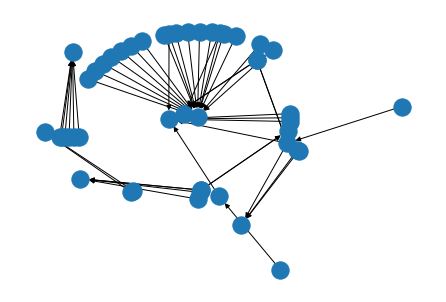

In [21]:
nx.draw_kamada_kawai(G)

In [23]:
# To have at least a simple parent-children relation saved, I am creating a simple df with parents and children columns. 
# Although this could be improved by showing both directions: parents <-> view <-> children

tree_df = tree_df.merge(pd.Series(child_dict).reset_index().rename({"index": "name", 0: "children"}, axis=1), on="name", how="left")

In [24]:
tree_df[~pd.isna(tree_df["children"])]

,name,sql,type,children
6,view_insurance_change_requests_global,"select\n icr.id\n , [product_generation_to_c...",view,"{test_bdx, view_insurance_chains_global, test_..."
8,helper_user_opened_referral_screen,"--yes_cache\nSELECT \n id as user_id, \n CAS...",view,"{test_two_dataset_customers, dataset_customers}"
9,view_credit_top_ups,select * from [view_credit_top_ups_global]\nwh...,view,"{view_cac_without_agreg_monthly, view_channel_..."
10,view_spent_credits_global,--yes_cache\nwith top_ups as (\n select\n ...,view,{view_spent_credits}
14,view_insurances_global,--yes_cache\nwith customer_churn as (\n selec...,view,"{test_bdx, view_investor_reporting, view_insur..."
17,helper_user_module_changes_since_acquisition,"--yes_cache\n\nselect\n user_id\n , count(ca...",view,"{test_two_dataset_customers, dataset_customers}"
20,view_premium_earned_global,with list_of_month as (\n select distinct [da...,view,{view_premium_earned}
21,view_testing_accounts,[query_testing_accounts],view,"{helper_user_premium_earned, view_cumulative_r..."
27,view_googlesheet_cac,--yes_cache\nselect\n acquisition_channel\n ...,view,"{view_cac_without_agreg_monthly, view_channel_..."
28,helper_user_tariffs,--yes_cache \nwith base as (\n select \n u...,view,"{test_two_dataset_customers, dataset_customers}"
